In [3]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('white')
sns.set_context('paper')

import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [18]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


<All keys matched successfully>

In [24]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(model, X)

In [25]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

[9.7697735e-01 9.7878389e-03 4.8781657e-03 1.2566481e-03 9.9159707e-04
 7.7776372e-04 4.7332360e-04 3.5362269e-04 3.0044562e-04 2.4441976e-04]


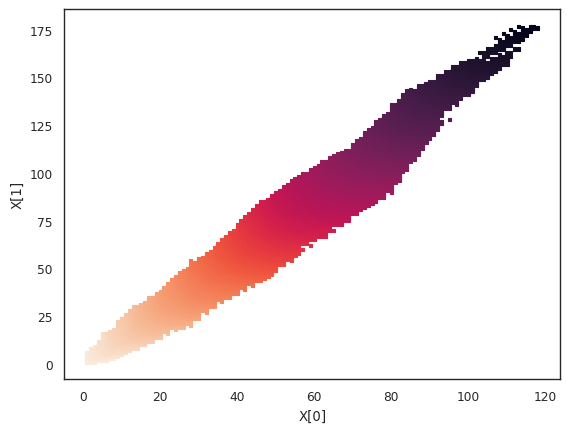

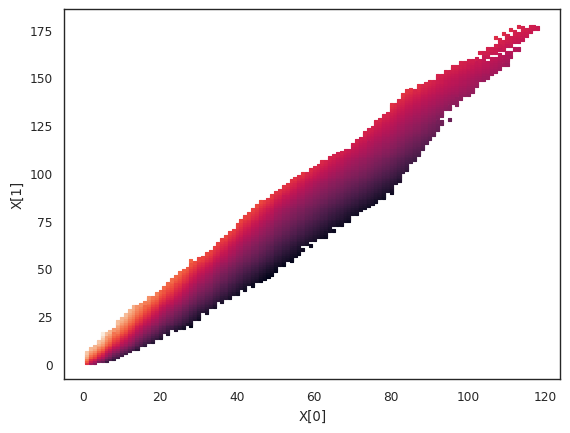

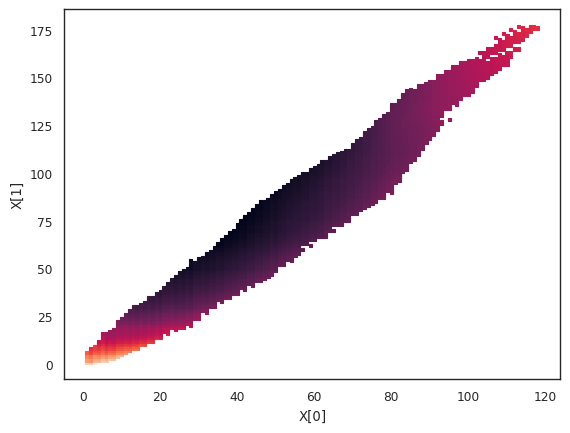

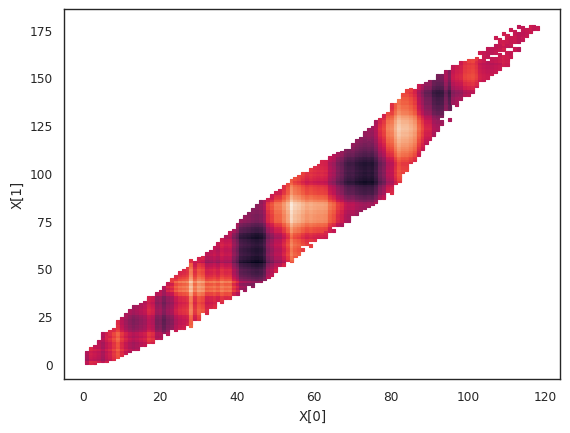

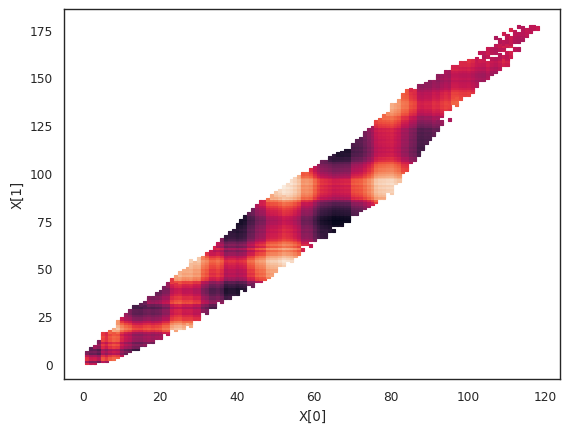

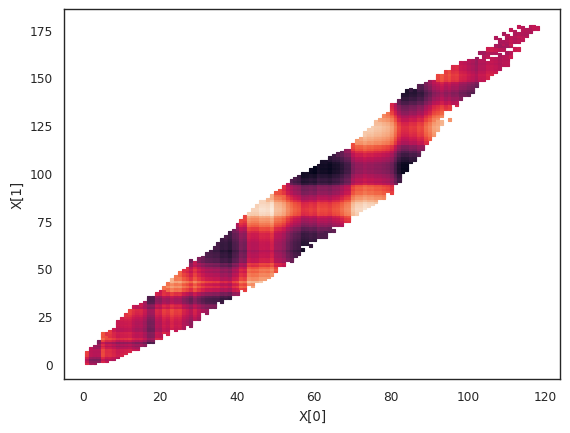

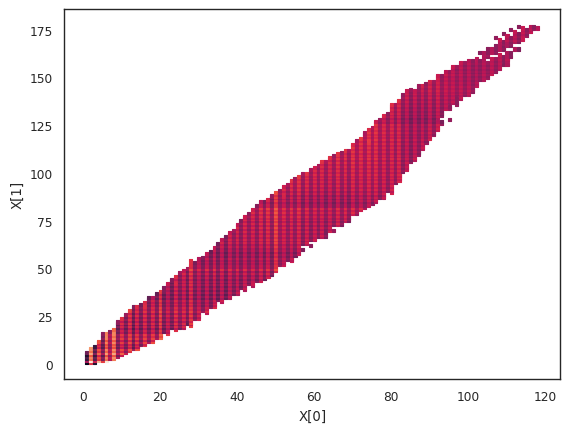

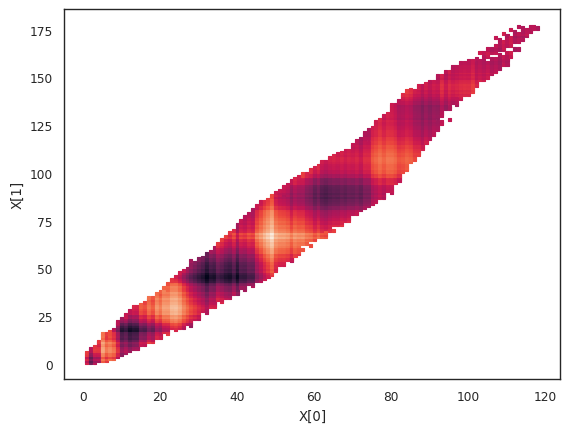

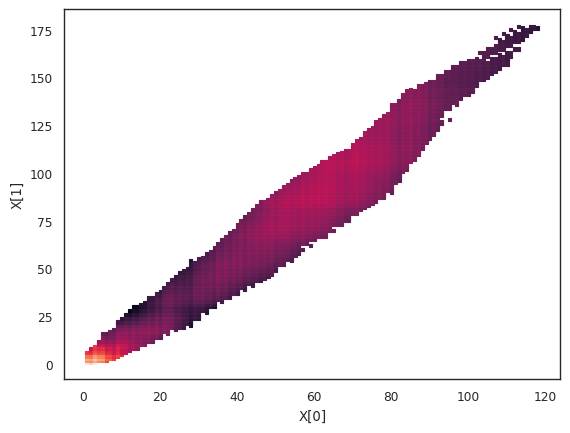

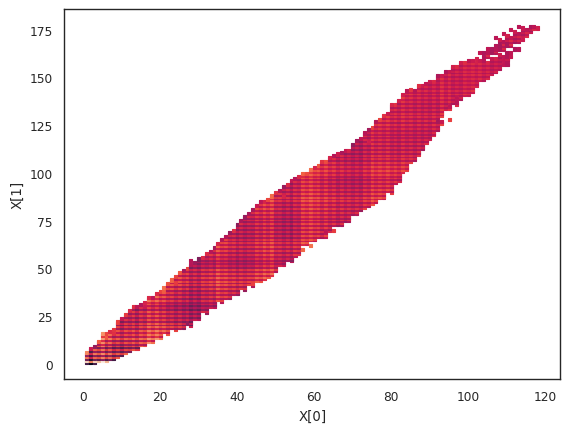

In [26]:
# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0], X[:, 1], c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()

In [27]:
from pysr import PySRRegressor
from functools import partial

sr_factory = partial(PySRRegressor,
    niterations=200,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
        "parity(x) = x % 2",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    ncyclesperiteration=300,
)

In [28]:
# catch warnigns
import warnings
import tqdm
import pickle
import time
FORCE = False

os.makedirs(f"plots/long-runs/{model_name}/equations", exist_ok=True)
inputs = X[:, :2].detach().cpu().numpy()
# fit the symbolic regression model to the data
equations = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(tqdm.tqdm(acts_pca.T)):
        time.sleep(2)
        fname = f"plots/long-runs/{model_name}/equations/{i}.pkl"
        if not os.path.exists(fname) or FORCE:
            sr = sr_factory()
            sr.fit(inputs, feature)
            equations.append(sr)
            # pickle.dump(sr, open(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
        else:
            equations.append(pickle.load(open(fname, 'rb')))

        # make predictions
        lowest_loss_idx = equations[-1].equations_.loss.argmin()
        y_pred = equations[-1].predict(inputs, lowest_loss_idx)
        recomputed_loss = ((feature - y_pred)**2).mean()

        loss = equations[-1].equations_.loss[lowest_loss_idx]
        print(f"Loss: {loss} vs {recomputed_loss}, var: {np.var(feature)}")
print("Done")

  0%|          | 0/10 [00:00<?, ?it/s]

Compiling Julia backend...


 10%|█         | 1/10 [01:41<15:13, 101.47s/it]

Started!

Expressions evaluated per second: 1.040e+05
Head worker occupation: 65.0%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 341 / 3000 total iterations (11.367%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.001e+01  1.594e+01  y = 8.1627e-05
2           2.972e+01  9.730e-03  y = inv(x₀)
3           2.380e+01  2.222e-01  y = (-0.027249 * x₁)
4           2.367e+01  5.106e-03  y = sin(0.051957 * x₀)
5           4.490e-01  3.965e+00  y = (10.54 + (-0.12967 * x₁))
7           1.420e-01  5.755e-01  y = (11.057 + (-0.079836 * (x₁ + x₀)))
9           1.418e-01  9.484e-04  y = ((11.069 + (-0.078284 * x₁)) + (-0.082259 * x₀))
10          1.339e-01  5.692e-02  y = ((11.058 + inv(x₀)) + (-0.079926 * (x₁ + x₀)))
11          1.337e-01  1.399e-03  y = ((11.058 + sin(inv(x₀))) + (-0.079926 

 20%|██        | 2/10 [02:14<08:11, 61.49s/it] 

Started!

Expressions evaluated per second: 1.240e+05
Head worker occupation: 57.4%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 462 / 3000 total iterations (15.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.006e-01  1.594e+01  y = 6.9335e-06
2           2.869e-01  4.675e-02  y = inv(x₀)
4           2.815e-01  9.532e-03  y = (inv(x₀) * 2.1365)
5           2.797e-01  6.206e-03  y = parity(inv(x₀ * 0.33388))
6           2.764e-01  1.190e-02  y = ((inv(x₀) * 2.5286) + -0.087959)
7           7.761e-02  1.270e+00  y = sin(x₀ * inv(0.22738 * x₁))
8           7.203e-02  7.469e-02  y = sin(x₀ * sin(inv(0.227 * x₁)))
9           3.177e-02  8.187e-01  y = sin(x₀ * inv((0.20828 * x₁) + 1.2637))
10          3.177e-02  2.205e-06  y = sin(x₀ * inv((sin(0.20981) * x₁) + 1.2638))
11         

In [24]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds_from_acts(acts):
    pred = model.readout(acts)
    pred = inverse_transform(pred, data)
    return pred[:, 0]

In [25]:
# combine the predictions of the symbolic regression models
# into a vector of features and use the same linear regression parameters from before
# to predict the output
sr_features = np.zeros((len(inputs), len(equations)))

for i, (sr, feat) in enumerate(zip(equations, acts_pca.T)):
    # idx = sr.equations_.score.values.argsort()[::-1][0] # select the best pareto front
    # idx = sr.equations_.loss.values.argsort()[0] # select the best equation by loss
    # pred = sr.predict(inputs, idx)
    pred = sr.predict(inputs)
    print((((pred - feat)**2).mean()), feat.std()**2)
    sr_features[:, i] = pred
sr_features = torch.tensor(sr_features, device=args.DEV).float()

print()
# We will get predictions in three different ways:
# 1. use the model readout layer
# 2. use a linear regression directly to the target
# 3. use a linear regression from the original PCA features

# 1. use the model readout layer
sr_features[:, 1:] = 0
acts = pca.inverse_transform(sr_features.detach().cpu().numpy())
acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print("Model readout layer", (pred - y).pow(2).mean().sqrt().item())


# 2. use a linear regression directly to the target
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(sr_features.detach().cpu().numpy(), y.detach().cpu().numpy())
pred = lr.predict(sr_features.detach().cpu().numpy())
print("Linear regression", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

0.42752548714609495 30.006171508724947
0.24182181043425263 0.0
0.13018379996605542 0.0
0.04063427915923774 0.0
0.033766134514868554 0.0
0.026956610952159635 0.0
0.013445481374146293 0.0
0.01317375430363284 0.0
0.010082577492527533 0.0
0.0024917216778305384 0.0

Model readout layer 61724.640428294675
Linear regression 16819.147184087546


In [26]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
acts_pca[:, 1:] = 0
acts = pca.inverse_transform(acts_pca)

acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print((pred - y).pow(2).mean().sqrt())

tensor(12446.5215, dtype=torch.float64, grad_fn=<SqrtBackward0>)


In [27]:
# now let's do direct SR on the final target
sr = sr_factory()
sr.fit(inputs, y.detach().cpu().numpy())


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:162: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(


Compiling Julia backend...


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
Juliaup configuration is locked by another process, waiting for it to unlock.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [27]:
pred = sr.predict(inputs, sr.equations_.loss.argmin())
print("SR", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

SR 2259288.174457114


In [29]:
# semf rms
Z, N = inputs.T
preds = (semi_empirical_mass_formula(Z, N))* (N+Z)
print("SEMF", ((preds - y.detach().cpu().numpy())**2).mean()**0.5)

SEMF 7928.02400004463


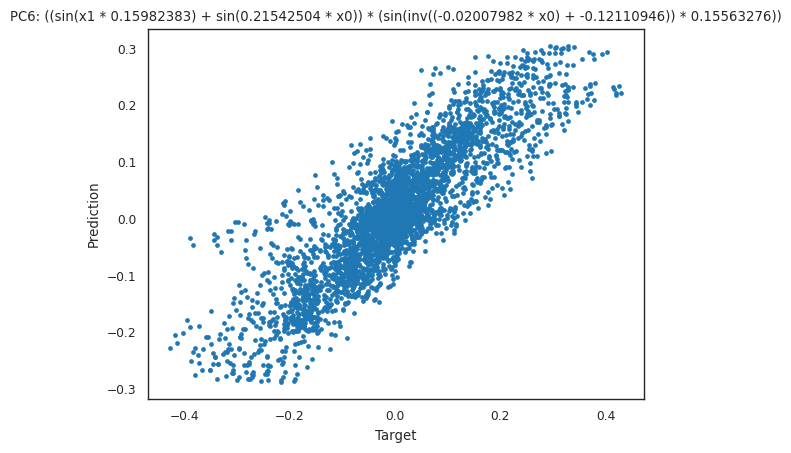

In [48]:
pc_idx = 6
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
idx = sr.equations_.loss.argmin()
function = equations[pc_idx].equations_.equation[idx]
preds = equations[pc_idx].predict(inputs, idx)
tgt = acts_pca[:, pc_idx]
plt.plot(tgt, preds, '.')
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"PC{pc_idx}: " + function)
plt.show()